<div style="text-align: center;">
  <div style="display: inline-block; min-width: 60%; font-weight: bold; font-size: 24px; color: white; background-color: blue; padding: 15px 20px; border: 2px solid white; border-radius: 8px;">
    PaddleOCR - PP-StructureV3 : Documents Pages Parsing
  </div>
</div>


# **1. Install Libraries**

In [1]:
%%capture
! python -m pip install paddlepaddle-gpu==3.0.0 -i https://www.paddlepaddle.org.cn/packages/stable/cu118/
! python -m pip install paddleocr

In [2]:
%%capture
! pip install markdown2

# **2. Import Libraries**

In [3]:
import logging
import time
from pathlib import Path
import pandas as pd
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
from PIL import Image
import os
import re

from IPython.display import display, HTML
import base64
import markdown
import markdown2

import io
from io import BytesIO, StringIO

import warnings
import sys
import contextlib

from paddleocr import PPStructureV3

Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/PaddleX3.0/fonts/PingFang-SC-Regular.ttf ...
[==================================================] 100.00%
Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/PaddleX3.0/fonts/simfang.ttf ...
[==================================================] 100.00%


# **3. Inference**

In [4]:
def parse_doc_pages_with_paddleocr(image_path):
    """
    Processes a document image using PaddleOCR's PPStructureV3 pipeline.

    Args:
        image_path (str): Path to the document image.

    Prints the structured prediction and saves results as JSON and Markdown files in the "output" directory.
    """
    pipeline = PPStructureV3(
        use_doc_orientation_classify=True,
        use_doc_unwarping=True,
        use_textline_orientation=True,
        device="gpu",
        use_chart_recognition=True
    )
    output = pipeline.predict(image_path)
    for res in output:
        res.save_to_json(save_path="output") ## Save the current image's structured result in JSON format
        res.save_to_markdown(save_path="output") ## Save the current image's result in Markdown format

In [5]:
def display_text_with_pdf_or_image_plain(markdown_path, file_path, pdf_page=0, max_width=800):
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    with open(markdown_path, "r", encoding="utf-8") as f:
        raw_text = f.read()
    
    # --- Image/PDF Display Part ---
    if file_path.lower().endswith(".pdf"):
        images = convert_from_path(file_path, first_page=pdf_page+1, last_page=pdf_page+1)
        img = images[0].convert("RGB")
    else:
        img = Image.open(file_path).convert("RGB")
    
    w_percent = max_width / float(img.width)
    new_height = int(float(img.height) * w_percent)
    img = img.resize((max_width, new_height), Image.LANCZOS)
    
    buffer = BytesIO()
    img.save(buffer, format="JPEG", quality=70)
    img_data = base64.b64encode(buffer.getvalue()).decode()
    html = f"""
    <div style="text-align: center;">
        <img src="data:image/jpeg;base64,{img_data}" style="width: 100%; border: 1px solid #ccc;" />
    </div>
    """
    display(HTML(html))

    # --- Markdown as plain text + tables as DataFrames ---
    html_tables = list(re.finditer(r'(<table[\s\S]*?</table>)', raw_text, re.IGNORECASE))
    last_end = 0
    for match in html_tables:
        text_before = raw_text[last_end:match.start()]
        if text_before.strip():
            print(text_before.strip())
            print('-' * 40)
        table_html = match.group(1)
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", FutureWarning)
                warnings.simplefilter("ignore", RuntimeWarning)
                df_list = pd.read_html(StringIO(table_html))
                for df in df_list:
                    df = df.fillna("")
                    df.columns = df.iloc[0]
                    df = df[1:].reset_index(drop=True)
                    display(df)
        except Exception as e:
            print("Error parsing HTML table:", e)
        last_end = match.end()
    # Print any remaining text after the last table
    if last_end < len(raw_text):
        text_after = raw_text[last_end:].strip()
        if text_after:
            print(text_after)

## **Example n°1**

In [6]:
parse_doc_pages_with_paddleocr("/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-10.jpg")

/usr/local/lib/python3.11/dist-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/766 [00:00<?, ?B/s]

inference.pdiparams:   0%|          | 0.00/6.75M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/330 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/32.1M [00:00<?, ?B/s]

Creating model: ('PP-DocBlockLayout', None)
Using official model (PP-DocBlockLayout), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.yml: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/129M [00:00<?, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

Creating model: ('PP-DocLayout_plus-L', None)
Using official model (PP-DocLayout_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.pdiparams:   0%|          | 0.00/129M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-LCNet_x1_0_textline_ori_infer.tar ...
[==================================================] 100.00%
Extracting PP-LCNet_x1_0_textline_ori_infer.tar
[==================================================] 100.00%


Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.yml:   0%|          | 0.00/903 [00:00<?, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/87.9M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/84.4M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

Creating model: ('PP-OCRv4_server_seal_det', None)
Using official model (PP-OCRv4_server_seal_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/925 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/114M [00:00<?, ?B/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_table_cls', None)
Using official model (PP-LCNet_x1_0_table_cls), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.pdiparams:   0%|          | 0.00/6.74M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.yml:   0%|          | 0.00/762 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

Creating model: ('SLANeXt_wired', None)
Using official model (SLANeXt_wired), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/365M [00:00<?, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

Creating model: ('SLANet_plus', None)
Using official model (SLANet_plus), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.yml: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/7.67M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

Creating model: ('RT-DETR-L_wired_table_cell_det', None)
Using official model (RT-DETR-L_wired_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/129M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

Creating model: ('RT-DETR-L_wireless_table_cell_det', None)
Using official model (RT-DETR-L_wireless_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

inference.json: 0.00B [00:00, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/129M [00:00<?, ?B/s]

Creating model: ('PP-FormulaNet_plus-L', None)
Using official model (PP-FormulaNet_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

inference.pdiparams:   0%|          | 0.00/728M [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

inference.yml: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

Creating model: ('PP-Chart2Table', None)
Using official model (PP-Chart2Table), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-Chart2Table_infer.tar ...
[==================================================] 100.00%
Extracting PP-Chart2Table_infer.tar
[==================================================] 100.00%


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/config.json
Loading weights file /root/.paddlex/official_models/PP-Chart2Table/model_state.pdparams
Loaded weights file from disk, setting weights to model.
All model checkpoint weights were used when initializing PPChart2TableInference.

All the weights of PPChart2TableInference were initialized from the model checkpoint at /root/.paddlex/official_models/PP-Chart2Table.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PPChart2TableInference for predictions without further training.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/generation_config.json
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/off

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]


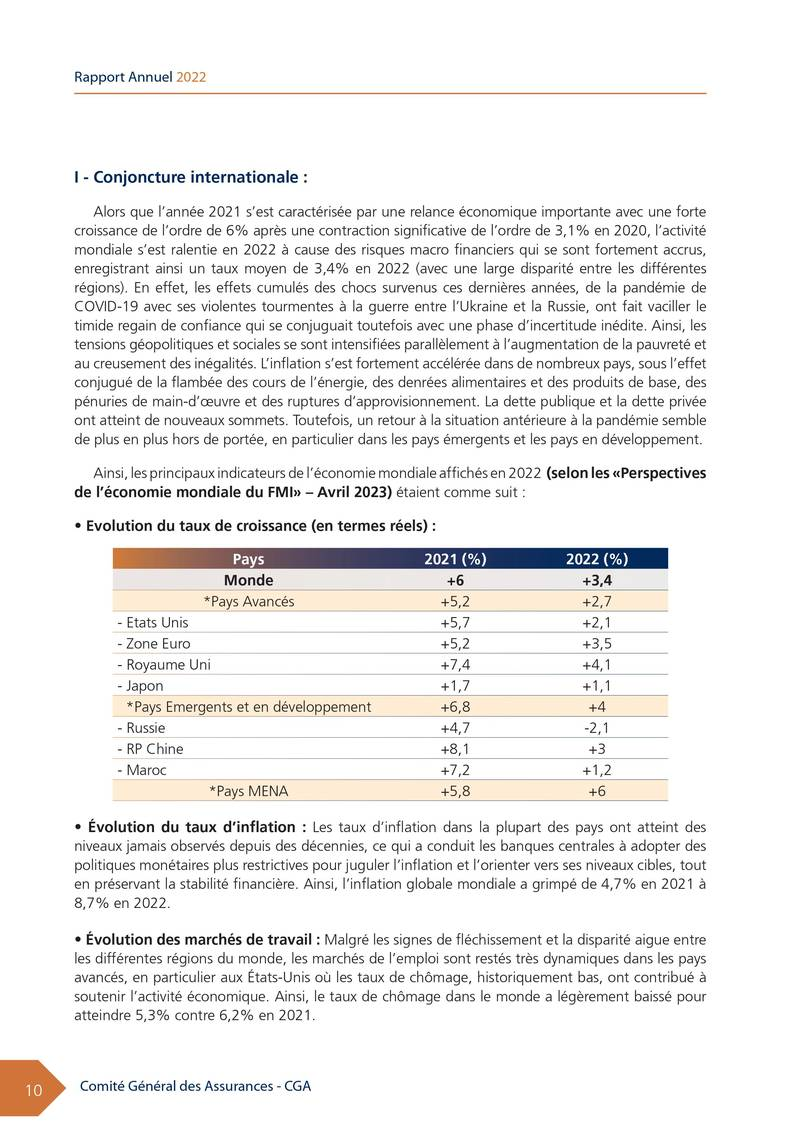

## I - Conjoncture internationale :

Alors que lannée2021 s'est caractérisée par une relance économique importante avec une forte croissance de l'ordre de6% après une contraction significative de lordre de 3,1% en2020,I'activitémondiale s'est ralentie en 2022 a cause des risques macro financiers qui se sont fortement accrus,enregistrant ainsi un taux moyen de3,4% en2022(avec une large disparité entre les différentes régions). En effet, les effets cumulés des chocs survenus ces dernières années, de la pandémie de COVID-19avec ses violentes tourmentes à la guerre entre I'Ukraine et la Russie,ont fait vaciller le timide regain de confiance qui se conjuguait toutefois avec une phase d'incertitude inédite. Ainsi, les tensions géopolitiques et sociales se sont intensifiées parallèlemental'augmentation de la pauvreté et aucreusement des inégalités. L'inflation sest fortement accélérée dans de nombreux pays,sousl'effet conjugué de la flambée des cours de l'énergie, des denrées alimentaires et 

,Pays,2021(%),2022(%)
0,Monde,+6,+34
1,*Pays Avancés,+52,+27
2,- EtatsUnis,+57,+21
3,- Zone Euro,+52,+35
4,- Royaume Uni,+74,+41
5,-Japon,+17,+11
6,*Pays Emergents et en développement,+68,+4
7,-Russie,+47,-21
8,-RP Chine,+81,+3
9,- Maroc,+72,+12


</body></html></div>


Evolution du taux d'inflation : Les taux d'inflation dans la plupart des pays ont atteint des niveaux jamais observés depuis des décennies, ce qui a conduit les banques centrales à adopter des politiques monétaires plus restrictives pour juguler l'inflation et l'orienter vers ses niveaux cibles, tout en préservant la stabilité financière. Ainsi, I'inflationglobale mondiale a grimpéde4,7% en2021 à8,7% en 2022.



• Évolution des marchés de travail :Malgré les signes de fléchissement et la disparité aigue entre les différentes régions du monde, les marchés de l'emploi sont restés très dynamiques dans les pays avancés, en particulier aux tats-Unis où les taux de chòmage,historiquement bas, ont contribué àsoutenir l'activité économique. Ainsi, le taux de chòmage dans le monde a légèrement baissé pour atteindre5,3% contre6,2% en2021.


In [7]:
display_text_with_pdf_or_image_plain("/kaggle/working/output/RAP_CGA_FR_ANG_2022-images-10.md", "/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-10.jpg")

## **Example n°2**

In [8]:
parse_doc_pages_with_paddleocr("/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-15.jpg")

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocBlockLayout', None)
Using official model (PP-DocBlockLayout), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocLayout_plus-L', None)
Using official model (PP-DocLayout_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv4_server_seal_det', None)
Using official model (PP-OCRv4_server_seal_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_table_cls', None)
Using official model (PP-LCNet_x1_0_table_cls), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANeXt_wired', None)
Using official model (SLANeXt_wired), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANet_plus', None)
Using official model (SLANet_plus), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wired_table_cell_det', None)
Using official model (RT-DETR-L_wired_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wireless_table_cell_det', None)
Using official model (RT-DETR-L_wireless_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-FormulaNet_plus-L', None)
Using official model (PP-FormulaNet_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-Chart2Table', None)
Using official model (PP-Chart2Table), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/config.json
Loading weights file /root/.paddlex/official_models/PP-Chart2Table/model_state.pdparams
Loaded weights file from disk, setting weights to model.
All model checkpoint weights were used when initializing PPChart2TableInference.

All the weights of PPChart2TableInference were initialized from the model checkpoint at /root/.paddlex/official_models/PP-Chart2Table.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PPChart2TableInference for predictions without further training.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/generation_config.json


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]


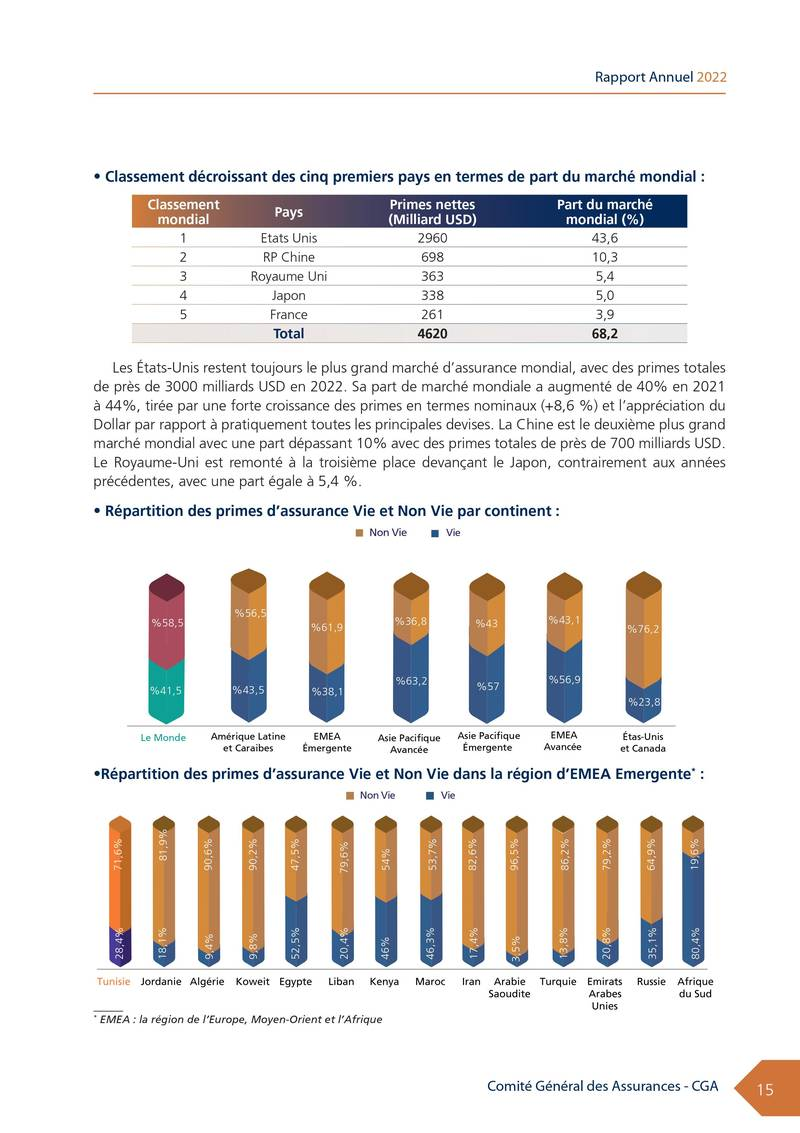

<div style="text-align: center;">• Classement décroissant des cinq premiers pays en termes de part du marché mondial :</div>



<div style="text-align: center;"><html><body>
----------------------------------------


,Classement mondial,Pays,Primes nettes (Milliard USD),Part du marché mondial (%)
0,1,Etats Unis,2960,436
1,2,RPChine,698,103
2,3,Royaume Uni,363,54
3,4,Japon,338,50
4,5,France,261,39
5,,Total,4620,682


</body></html></div>


Les États-Unis restent toujours le plus grand marché d'assurance mondial, avec des primes totales de prèsde3000milliardsUSDen2022.Sa partde marché mondiale a augmenté de40% en2021à 44%, tirée par une forte croissance des primes en termes nominaux (+8,6 %) et l'appréciation du Dollar par rapportà pratiquement toutes les principalesdevises. LaChine est le deuxième plus grand marché mondial avec une part dépassant10% avec des primes totales de près de700milliards UsD.Le Royaume-Uni est remonté à la troisième place devançant le Japon, contrairement aux années précédentes,avec une part égale à 5,4%.



<div style="text-align: center;">Répartition des primes d'assurance Vie et Non Vie par continent :</div>


<div style="text-align: center;"><img src="imgs/img_in_chart_box_389_1619_2079_2326.jpg" alt="Image" width="68%" /></div>


<div style="text-align: center;">Répartition des primes d'assurance Vie et Non Vie dans la région d'EMEA Emergente*</div>


<div style="text-

In [9]:
display_text_with_pdf_or_image_plain("/kaggle/working/output/RAP_CGA_FR_ANG_2022-images-15.md", "/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-15.jpg")

## **Example n°3**

In [10]:
parse_doc_pages_with_paddleocr("/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-17.jpg")

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocBlockLayout', None)
Using official model (PP-DocBlockLayout), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocLayout_plus-L', None)
Using official model (PP-DocLayout_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv4_server_seal_det', None)
Using official model (PP-OCRv4_server_seal_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_table_cls', None)
Using official model (PP-LCNet_x1_0_table_cls), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANeXt_wired', None)
Using official model (SLANeXt_wired), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANet_plus', None)
Using official model (SLANet_plus), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wired_table_cell_det', None)
Using official model (RT-DETR-L_wired_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wireless_table_cell_det', None)
Using official model (RT-DETR-L_wireless_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-FormulaNet_plus-L', None)
Using official model (PP-FormulaNet_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-Chart2Table', None)
Using official model (PP-Chart2Table), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/config.json
Loading weights file /root/.paddlex/official_models/PP-Chart2Table/model_state.pdparams
Loaded weights file from disk, setting weights to model.
All model checkpoint weights were used when initializing PPChart2TableInference.

All the weights of PPChart2TableInference were initialized from the model checkpoint at /root/.paddlex/official_models/PP-Chart2Table.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PPChart2TableInference for predictions without further training.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/generation_config.json


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]


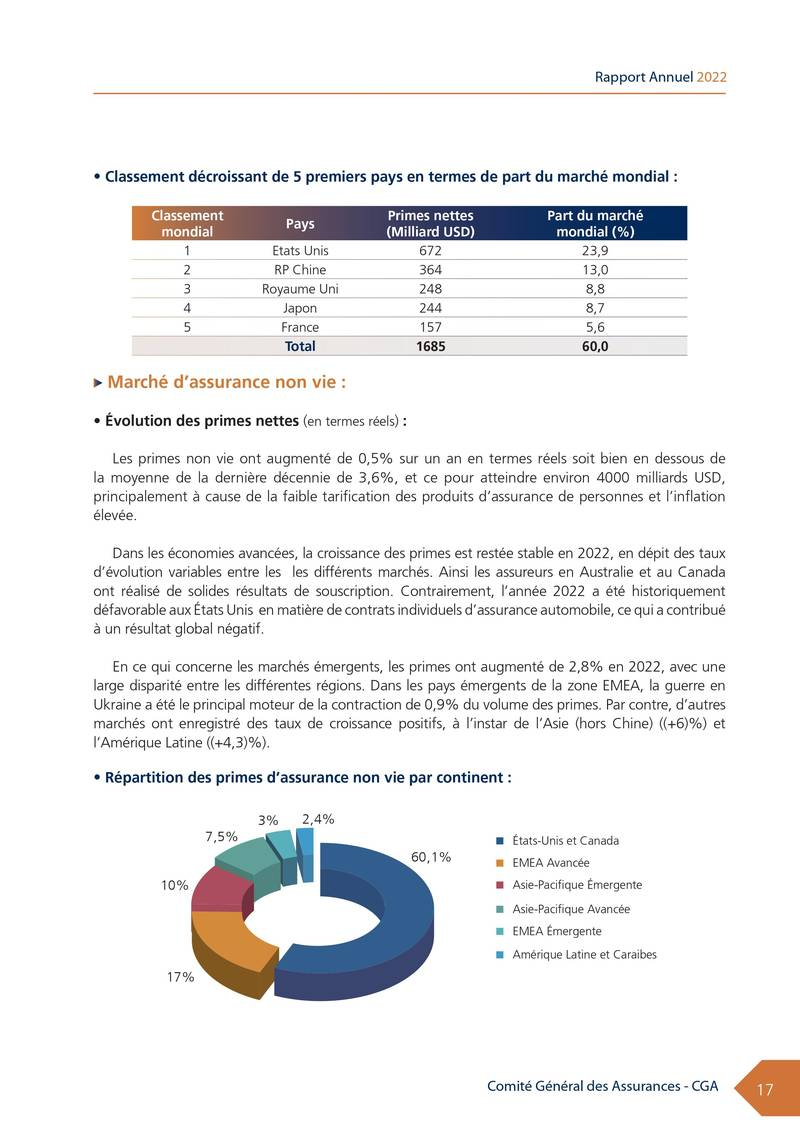

<div style="text-align: center;">• Classement decroissant de 5 premiers pays en termes de part du marché mondial :</div>



<div style="text-align: center;"><html><body>
----------------------------------------


,Classement mondial,Pays,Primes nettes (Milliard USD),Part du marché mondial (%)
0,1,Etats Unis,672,239
1,2,RPChine,364,130
2,3,Royaume Uni,248,88
3,4,Japon,244,87
4,5,France,157,56
5,,Total,1685,600


</body></html></div>


## Marché d'assurance non vie :

## Évolution des primes nettes (en termes réels) :

Les primes non vie ont augmenté de 0,5% sur un an en termes réels soit bien en dessous de la moyenne de la dernière décennie de3,6%,et ce pour atteindre environ 4000 milliards USD,principalementà cause de la faible tarification des produits d'assurancede personnes et I'inflation élevée.



Dans les économies avancées, la croissance des primes est restée stable en2022, en dépit des taux d'évolution variables entre les les différents marchés. Ainsi les assureurs en Australie et au Canada ont réalisé de solides résultats de souscription. Contrairement, I'année 2022 a été historiquement défavorable aux États Unis en matière de contrats individuels d'assurance automobile, ce qui a contribuéà un résultat global négatif.



En ce qui concerne les marchés émergents, les primes ont augmenté de 2,8% en2022,avec une large disparité entre les différentes régions. Dans les pays émergents de l

In [11]:
display_text_with_pdf_or_image_plain("/kaggle/working/output/RAP_CGA_FR_ANG_2022-images-17.md", "/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-17.jpg")

## **Example n°4**

In [12]:
parse_doc_pages_with_paddleocr("/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-79 (1) (1).jpg")

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocBlockLayout', None)
Using official model (PP-DocBlockLayout), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocLayout_plus-L', None)
Using official model (PP-DocLayout_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv4_server_seal_det', None)
Using official model (PP-OCRv4_server_seal_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_table_cls', None)
Using official model (PP-LCNet_x1_0_table_cls), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANeXt_wired', None)
Using official model (SLANeXt_wired), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANet_plus', None)
Using official model (SLANet_plus), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wired_table_cell_det', None)
Using official model (RT-DETR-L_wired_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wireless_table_cell_det', None)
Using official model (RT-DETR-L_wireless_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-FormulaNet_plus-L', None)
Using official model (PP-FormulaNet_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-Chart2Table', None)
Using official model (PP-Chart2Table), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/config.json
Loading weights file /root/.paddlex/official_models/PP-Chart2Table/model_state.pdparams
Loaded weights file from disk, setting weights to model.
All model checkpoint weights were used when initializing PPChart2TableInference.

All the weights of PPChart2TableInference were initialized from the model checkpoint at /root/.paddlex/official_models/PP-Chart2Table.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PPChart2TableInference for predictions without further training.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/generation_config.json


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]


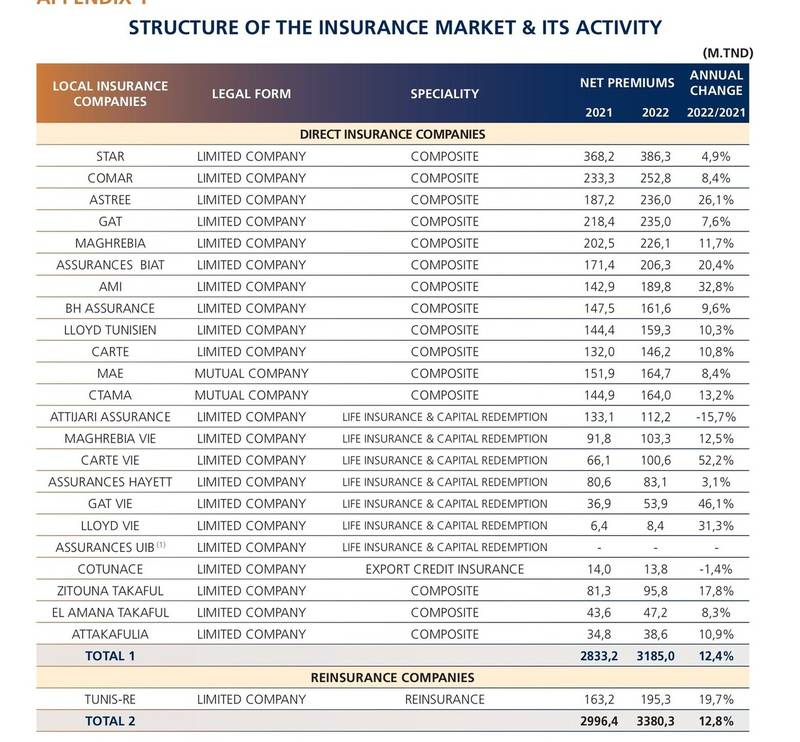

<div style="text-align: center;">STRUCTUREOF THE INSURANCEMARKET&ITSACTIVITY </div>


(M.TND)


<div style="text-align: center;"><html><body>
----------------------------------------


,LOCALINSURANCE COMPANIES,LEGALFORM,SPECIALITY,NETPREMIUMS,NETPREMIUMS,ANNUAL CHANGE 2022/2021
0,LOCALINSURANCE COMPANIES,LEGALFORM,SPECIALITY,2021,2022,
1,,,,,,
2,,DIRECT INSURANCECOMPANIES,,,,
3,STAR,LIMITEDCOMPANY,COMPOSITE,3682,3863,"4,9%"
4,COMAR,LIMITEDCOMPANY,COMPOSITE,2333,2528,"8,4%"
5,ASTREE,LIMITEDCOMPANY,COMPOSITE,1872,2360,"26,1%"
6,GAT,LIMITED COMPANY,COMPOSITE,2184,2350,"7,6%"
7,MAGHREBIA,LIMITEDCOMPANY,COMPOSITE,2025,2261,"11,7%"
8,ASSURANCES BIAT,LIMITEDCOMPANY,COMPOSITE,1714,2063,"20,4%"
9,AMI,LIMITEDCOMPANY,COMPOSITE,1429,1898,"32,8%"


</body></html></div>


In [13]:
display_text_with_pdf_or_image_plain("/kaggle/working/output/RAP_CGA_FR_ANG_2022-images-79 (1) (1).md", "/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-79 (1) (1).jpg")

## **Example n°5**

In [14]:
parse_doc_pages_with_paddleocr("/kaggle/input/pdf-files-pages/2023-annual-report_page-0110.jpg")

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocBlockLayout', None)
Using official model (PP-DocBlockLayout), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocLayout_plus-L', None)
Using official model (PP-DocLayout_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv4_server_seal_det', None)
Using official model (PP-OCRv4_server_seal_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_table_cls', None)
Using official model (PP-LCNet_x1_0_table_cls), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANeXt_wired', None)
Using official model (SLANeXt_wired), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANet_plus', None)
Using official model (SLANet_plus), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wired_table_cell_det', None)
Using official model (RT-DETR-L_wired_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wireless_table_cell_det', None)
Using official model (RT-DETR-L_wireless_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-FormulaNet_plus-L', None)
Using official model (PP-FormulaNet_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-Chart2Table', None)
Using official model (PP-Chart2Table), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/config.json
Loading weights file /root/.paddlex/official_models/PP-Chart2Table/model_state.pdparams
Loaded weights file from disk, setting weights to model.
All model checkpoint weights were used when initializing PPChart2TableInference.

All the weights of PPChart2TableInference were initialized from the model checkpoint at /root/.paddlex/official_models/PP-Chart2Table.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PPChart2TableInference for predictions without further training.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/generation_config.json


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]


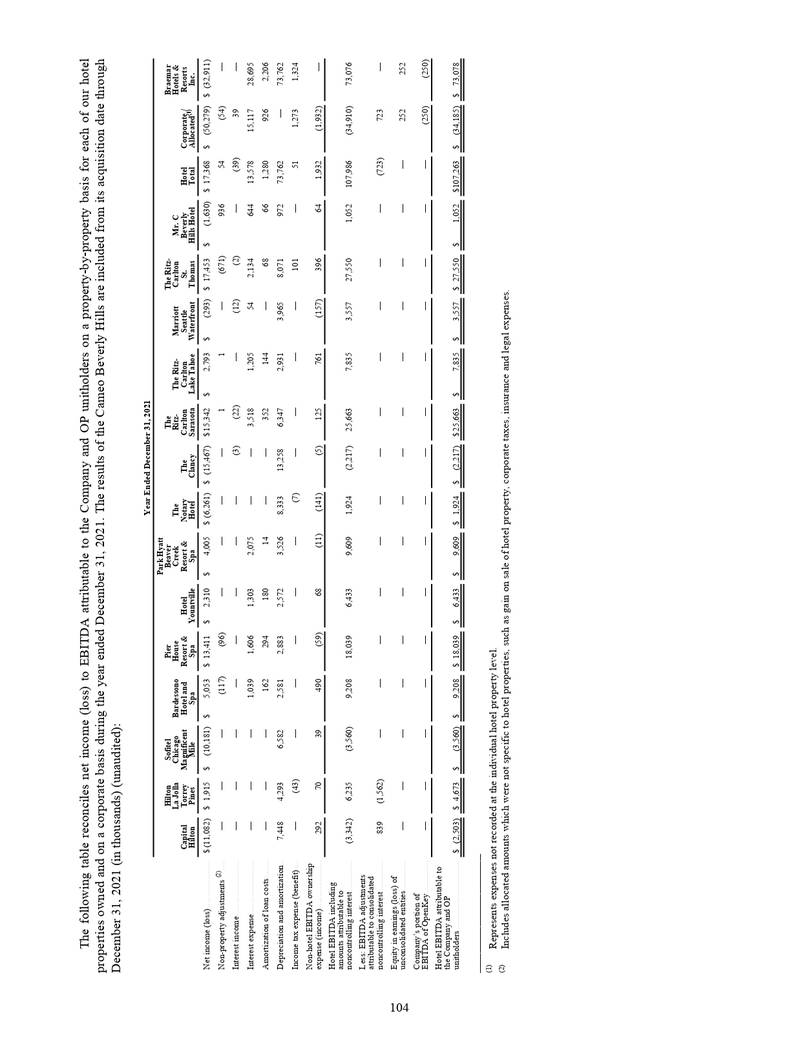

<div style="text-align: center;">Represents expenses not recorded at the individual hotel property level.Includesalloctedamountswhichwrenotspciictohotlproprtiucasgaionaleofhotelproprtycororatetaxsinuranceandalexpnses.a C </div>



<div style="text-align: center;"><html><body>
----------------------------------------


,,,,,,,,,,,,,,,,,,,,
0,,,,,,,,Capital Hilton,Hilton La Jolla Torrey Pines,Sofitel Chicago Magnificent Mile,,Bardessono Hotel and Spa,Pier House Resort & Spa,,Hotel Yountville,Park Hyatt Beaver Creek Resort & Spa,The Notary Hotel,The Clancy,The Ritz- Carlton Sarasota,The Ritz- Carlton Lake Taho e
1,Net income (loss),"$(11,082)","$ 1,915","$ (10,181)","$ 5,053","$ 13,411","$ 2,310","$ 4,005","$ (6,261)","$ (15,467)","$15,342","$ 2,793",$ (293),"$ 17,453","$ (1,630)","$ 17,368","$ (50,279)","$ (32,911)",,
2,Non-property adjustments 2 Interest income,,,,(117),(96),/,,,,1,1,一,(671),936,54,(54),,,
3,,,,1039,1606,1303,,,(3),(22),,(12),(2),,(39),39,,,,
4,Interest expense,,,,2075,,,3518,1205,54,2134,644,13578,15117,28695,,,,,
5,Amortization of loan costs,,4293,,162,294,180,14,,,352,144,,68,66,1280,926,2206,,
6,Depreciation and amortization,7448,6582,2581,2883,2572,3526,8333,13258,6347,2931,3965,8071,972,73762,,73762,,,
7,Income tax expense (benefit),—,(43),一,一,一,—,一,(7),一,一,一,一,101,一,51,1273,1324,Non-hotel EBITDA ownership expense (income),
8,Hotel EBITDA including amounts attributable to,"(3,342)",6235,"(3,560)",9208,18039,9609,1924,"(2,217)",25663,7835,3557,27550,107986,,73076,,,,
9,noncontrollimg interest,6433,1052,"(34,910)",Less: EBITDA adjustments attributable to conso...,839,"(1,562)",—,_,(723),723,一,noncontrollimg interest,二,1,_,_,—,,


</body></html></div>


<div style="text-align: center;">Year Ended December 31, 2021</div>


<div style="text-align: center;">December 31, 2021 (in thousands) (unaudited):propertiesownedandoncorporaebasisduring theyeaendedDecember12.TheresultoftheCameo BevrlHillareincludedromit acquisitondaetrou The followin tabl reconcilet incomelossto EBTDA attributabletothe Compny andOP untholeroaroperty-by-propertbasis foracofour hotel </div>


In [17]:
display_text_with_pdf_or_image_plain("/kaggle/working/output/2023-annual-report_page-0110.md", "/kaggle/input/pdf-files-pages/2023-annual-report_page-0110.jpg")

## **Example n°7**

In [19]:
parse_doc_pages_with_paddleocr("/kaggle/input/pdf-files-pages/CLAS-FY2023-AR_page-0076.jpg")

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocBlockLayout', None)
Using official model (PP-DocBlockLayout), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocLayout_plus-L', None)
Using official model (PP-DocLayout_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv4_server_seal_det', None)
Using official model (PP-OCRv4_server_seal_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_table_cls', None)
Using official model (PP-LCNet_x1_0_table_cls), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANeXt_wired', None)
Using official model (SLANeXt_wired), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANet_plus', None)
Using official model (SLANet_plus), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wired_table_cell_det', None)
Using official model (RT-DETR-L_wired_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wireless_table_cell_det', None)
Using official model (RT-DETR-L_wireless_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-FormulaNet_plus-L', None)
Using official model (PP-FormulaNet_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-Chart2Table', None)
Using official model (PP-Chart2Table), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/config.json
Loading weights file /root/.paddlex/official_models/PP-Chart2Table/model_state.pdparams
Loaded weights file from disk, setting weights to model.
All model checkpoint weights were used when initializing PPChart2TableInference.

All the weights of PPChart2TableInference were initialized from the model checkpoint at /root/.paddlex/official_models/PP-Chart2Table.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PPChart2TableInference for predictions without further training.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/generation_config.json


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]


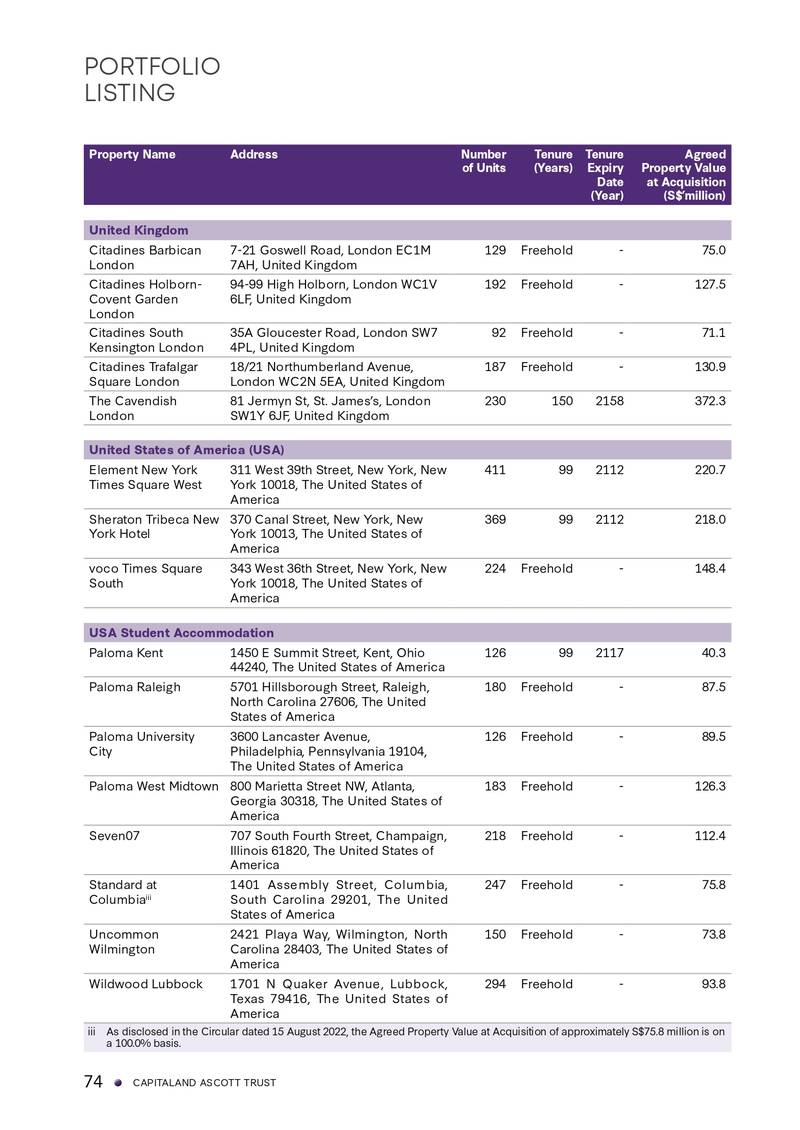

<div style="text-align: center;"><html><body>
----------------------------------------


,Property Name,Address,Number of Units,Tenure (Years),Tenure Expiry Date (Year),Agreed Property Value at Acquisition (S$'million)
0,,,,,,
1,,,,,,
2,United Kingdom,,129,Freehold,-,75.0
3,Citadines Holborn- Covent Garden London,"94-99 High Holborn, London WC1V 6LF, United Ki...",192,Freehold,-,127.5
4,Citadines South Kensington London Citadines Tr...,"35A Gloucester Road, London SW7 4PL, United Ki...",92,Freehold,-,71.1 130.9
5,"18/21 Northumberland Avenue, London WC2N 5EA, ...",187,Freehold,-,,
6,The Cavendish London,"81 Jermyn St, St. James's, London SW1Y 6JF,Uni...",230,150,2158,372.3
7,United States of America (USA),United States of America (USA),United States of America (USA),United States of America (USA),United States of America (USA),United States of America (USA)
8,Element New York Times Square West,"311 West 39th Street, New York, New York 10018...",411,66,2112,220.7
9,York Hotel,York 10013. The United States of America,369,99,2112,218.0


</body></html></div>


In [20]:
display_text_with_pdf_or_image_plain("/kaggle/working/output/CLAS-FY2023-AR_page-0076.md", "/kaggle/input/pdf-files-pages/CLAS-FY2023-AR_page-0076.jpg")

## **Example n°8**

In [21]:
parse_doc_pages_with_paddleocr("/kaggle/input/pdf-files-pages/CLAS-FY2023-AR_page-0066.jpg")

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocBlockLayout', None)
Using official model (PP-DocBlockLayout), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocLayout_plus-L', None)
Using official model (PP-DocLayout_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv4_server_seal_det', None)
Using official model (PP-OCRv4_server_seal_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_table_cls', None)
Using official model (PP-LCNet_x1_0_table_cls), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANeXt_wired', None)
Using official model (SLANeXt_wired), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANet_plus', None)
Using official model (SLANet_plus), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wired_table_cell_det', None)
Using official model (RT-DETR-L_wired_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wireless_table_cell_det', None)
Using official model (RT-DETR-L_wireless_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-FormulaNet_plus-L', None)
Using official model (PP-FormulaNet_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-Chart2Table', None)
Using official model (PP-Chart2Table), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/config.json
Loading weights file /root/.paddlex/official_models/PP-Chart2Table/model_state.pdparams
Loaded weights file from disk, setting weights to model.
All model checkpoint weights were used when initializing PPChart2TableInference.

All the weights of PPChart2TableInference were initialized from the model checkpoint at /root/.paddlex/official_models/PP-Chart2Table.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PPChart2TableInference for predictions without further training.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/generation_config.json


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]


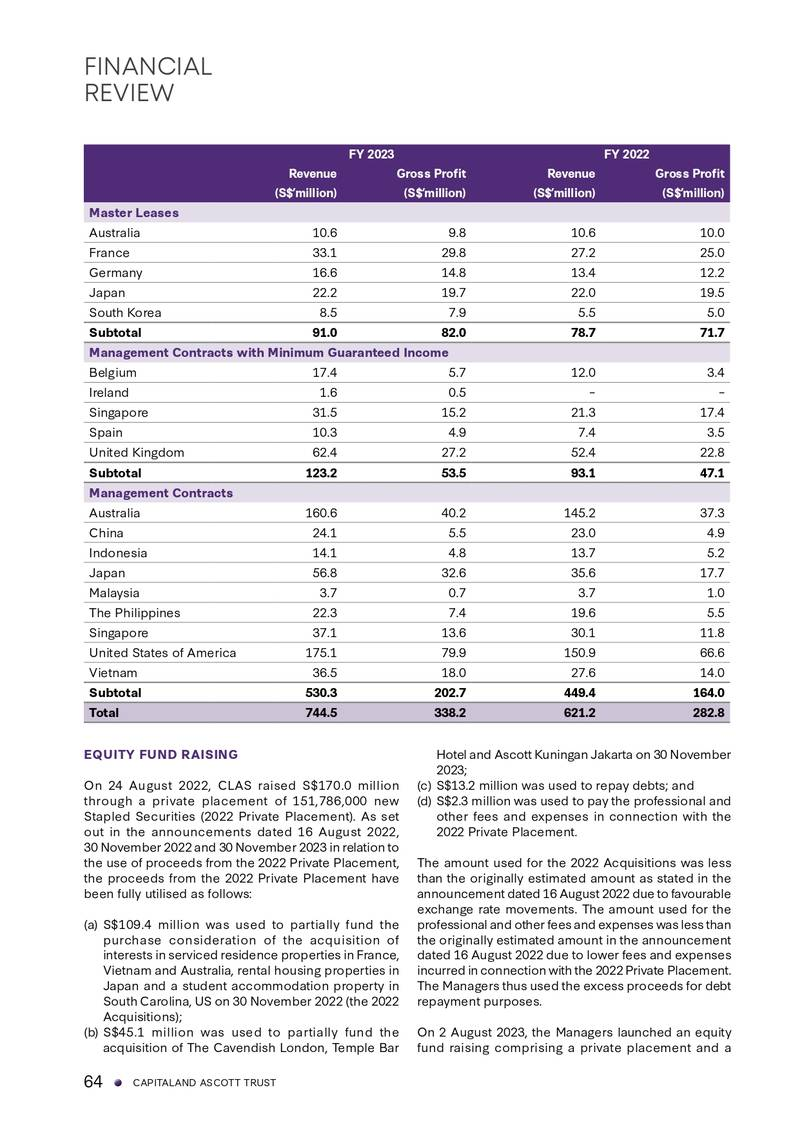

<div style="text-align: center;"><html><body>
----------------------------------------


,EY 2023,FY 2022,FY 2022,,
0,EY 2023,Reyenue (S$'million),Gross Profit (S$'million),Revenue (S$'million),Gross Profit (S$'million)
1,Master Leases,,,,
2,Australia,10.6,9.8,10.6,10.0
3,France,33.1,29.8,27.2,25.0
4,Germany,,16.6,14.8,13.4
5,Japan,22.2,19.7,22.0,19.5
6,South Korea,8.5,7.9,5.5,5.0
7,Subtotal,91.0,82.0,78.7,71.7
8,cYnaaGY,,,,
9,Belgium 17.4 5.7,5.7,12.0,3.4,


</body></html></div>


## EQUITYFUNDRAISING 

On 24 August 2022, CLAS raised S$170.0 million through a private placement of 151,786,000 new Stapled Securities (2022 Private Placement). As set out in the announcements dated 16 August 2022,30 November 2022 and 30 November 2023 in relation to the use of proceeds from the 2022 Private Placement,the proceeds from the 2022 Private Placement have been fully utilised as follows:

(a) S$109.4 million was used to partially fund the purchase consideration of the acquisition of interests in serviced residence properties in France,Vietnam and Australia, rental housing properties in Japan and a student accommodation property in South Carolina, US on 30 November 2022 (the 2022Acquisitions);

(b) S$45.1 million was used to partially fund the acquisition of The Cavendish London, Temple Bar Hotel and Ascott Kuningan Jakarta on 30 November 2023;

(c) S$13.2 million was used to repay debts; and 

(d) S$2.3 million was used to pay the professional and othe

In [22]:
display_text_with_pdf_or_image_plain("/kaggle/working/output/CLAS-FY2023-AR_page-0066.md", "/kaggle/input/pdf-files-pages/CLAS-FY2023-AR_page-0066.jpg")

## **Example n°9**

In [23]:
parse_doc_pages_with_paddleocr("/kaggle/input/pdf-files-pages/Marriott International Reports Third Quarter 2024 Results_page-0011.jpg")

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocBlockLayout', None)
Using official model (PP-DocBlockLayout), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-DocLayout_plus-L', None)
Using official model (PP-DocLayout_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv4_server_seal_det', None)
Using official model (PP-OCRv4_server_seal_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_table_cls', None)
Using official model (PP-LCNet_x1_0_table_cls), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANeXt_wired', None)
Using official model (SLANeXt_wired), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('SLANet_plus', None)
Using official model (SLANet_plus), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wired_table_cell_det', None)
Using official model (RT-DETR-L_wired_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('RT-DETR-L_wireless_table_cell_det', None)
Using official model (RT-DETR-L_wireless_table_cell_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-FormulaNet_plus-L', None)
Using official model (PP-FormulaNet_plus-L), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-Chart2Table', None)
Using official model (PP-Chart2Table), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/config.json
Loading weights file /root/.paddlex/official_models/PP-Chart2Table/model_state.pdparams
Loaded weights file from disk, setting weights to model.
All model checkpoint weights were used when initializing PPChart2TableInference.

All the weights of PPChart2TableInference were initialized from the model checkpoint at /root/.paddlex/official_models/PP-Chart2Table.
If your task is similar to the task the model of the checkpoint was trained on, you can already use PPChart2TableInference for predictions without further training.
Loading configuration file /root/.paddlex/official_models/PP-Chart2Table/generation_config.json


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]


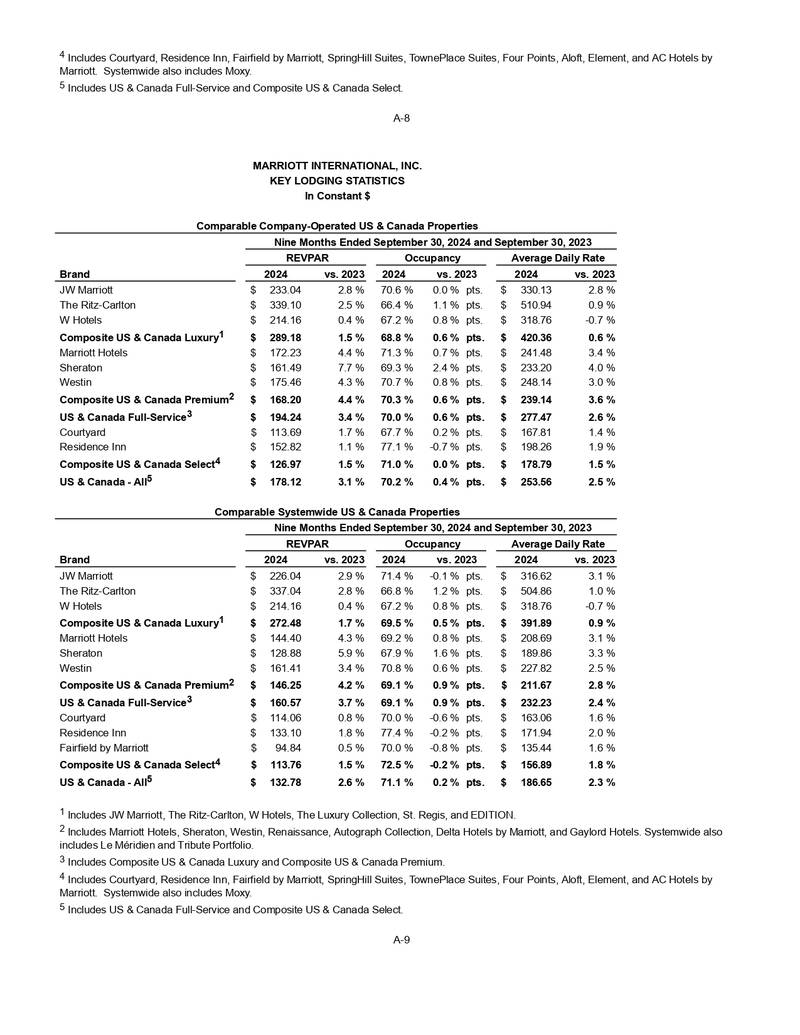

4Iullul Marriott. Systemwide also includes Moxy 



5 Includes US & Canada Full-Service and Composite US & Canada Select.

## A-8

### MARRIOTT INTERNATIONAL, INC.KEY LODGING STATISTICS In Constant $ 

<div style="text-align: center;">Comparable Company-Operated US & Canada Properties </div>



<div style="text-align: center;"><html><body>
----------------------------------------


,,"Nine Months Ended September 30, 2024 and September 30,2023","Nine Months Ended September 30, 2024 and September 30,2023","Nine Months Ended September 30, 2024 and September 30,2023","Nine Months Ended September 30, 2024 and September 30,2023","Nine Months Ended September 30, 2024 and September 30,2023","Nine Months Ended September 30, 2024 and September 30,2023","Nine Months Ended September 30, 2024 and September 30,2023","Nine Months Ended September 30, 2024 and September 30,2023"
0,,REVPAR,REVPAR,Occupancy,Occupancy,Occupancy,Average Daily Rate,Average Daily Rate,Average Daily Rate
1,,2024 Vs.2023,2024 Vs.2023,2024 Vs.2023,2024 vs.2023,2024 vs.2023,2024,2024,vs. 2023
2,Brand JW Marriott,$,233.04,2.8% 70.6%,,0.0% pts.,$,330.13,2.8 %
3,The Ritz-Carlton,$,339.10,2.5%,66.4 %,1.1% pts.,$,510.94,0.9 %
4,W Hotels,$,214.16,0.4%,67.2 %,0.8% pts.,$,318.76,-0.7%
5,Composite US & Canada Luxury1,$,289.18,1.5%,68.8%,0.6% pts.,$,420.36,0.6%
6,Marriott Hotels,$,172.23,4.4 %,71.3 %,0.7% pts.,$,241.48,3.4%
7,Sheraton,$,161.49,7.7 %,69.3%,2.4% pts.,$,233.20,4.0 %
8,Westin,$,175.46,4.3%,70.7 %,0.8% pts.,$,248.14,3.0 %
9,Composite US & Canada Premium2,$,168.20,4.4 %,70.3%,0.6% pts.,,$ 239.14,3.6%


</body></html></div>


<div style="text-align: center;">Comparable Systemwide US & Canada Properties </div>



<div style="text-align: center;"><html><body>
----------------------------------------


,,"Nine Months Ended September 30, 2024 and September 30, 2023","Nine Months Ended September 30, 2024 and September 30, 2023","Nine Months Ended September 30, 2024 and September 30, 2023","Nine Months Ended September 30, 2024 and September 30, 2023","Nine Months Ended September 30, 2024 and September 30, 2023","Nine Months Ended September 30, 2024 and September 30, 2023","Nine Months Ended September 30, 2024 and September 30, 2023","Nine Months Ended September 30, 2024 and September 30, 2023"
0,,REVPAR,REVPAR,Occupancy,Occupancy,Occupancy,Average Daily Rate,Average Daily Rate,Average Daily Rate
1,,2024 Vs.2023,2024 Vs.2023,2024 Vs.2023,2024 vs.2023,2024 vs.2023,2024,2024,
2,Brand JW Marriott,$,226.04,2.9 % 71.4 %,,-0.1% pts.,$,Vs.2023 316.62 3.1%,
3,The Ritz-Carlton,$,337.04,2.8% 66.8%,,1.2% pts.,$,504.86 1.0 %,
4,W Hotels,$,214.16,0.4% 67.2%,0.8% pts.,,$ 318.76,-0.7%,
5,Composite US & Canada Luxury1,$,272.48 1.7 %,69.5%,0.5% pts.,,$ 391.89,0.9%,
6,Marriott Hotels,$,144.40,4.3 % 69.2 %,0.8% pts.,,$ 208.69,3.1%,
7,Sheraton,$,128.88 5.9%,67.9 %,1.6% pts.,,$ 189.86,3.3%,
8,Westin,$,161.41 3.4%,70.8 %,0.6% pts.,,$ 227.82,2.5%,
9,Composite US & Canada Premium2,$,146.25,4.2 % 69.1%,0.9% pts.,,$,211.67 2.8 %,


</body></html></div>


In [24]:
display_text_with_pdf_or_image_plain(
    "/kaggle/working/output/Marriott International Reports Third Quarter 2024 Results_page-0011.md", 
    "/kaggle/input/pdf-files-pages/Marriott International Reports Third Quarter 2024 Results_page-0011.jpg"
)